# Introduction

In this project, we will examine a dataset of hotel bookings for two hotels, a resort hotel and a city hotel, in Portugal from 2015 to 2017. The goals of the project are to understand the patterns of bookings at the hotels, explore how cancellations may be related to different variables such as time or number of guests, and develop a model to help predict which bookings are likely to be canceled so hotels can better manage their room inventory.

Sources:

Dataset was obtained from Kaggle [here](https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand).

Original article by Antonio et al. 2019 [here](https://www.sciencedirect.com/science/article/pii/S2352340918315191).


# Import  Python modules and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels.api as sm
from statsmodels.formula.api import logit
plt.rcParams["figure.figsize"] = (9, 6)

In [2]:
hotels = pd.read_csv('hotels.csv')
hotels.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/2015
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,7/2/2015
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,7/2/2015
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,7/3/2015


# Data Cleansing

In [3]:
hotels.shape

(119390, 32)

In [4]:
hotels.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [5]:
hotels.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [6]:
#Correct columns' data types
hotels = hotels.astype({'is_canceled':'bool', 'is_repeated_guest':'bool','arrival_date_year':'str', 'arrival_date_day_of_month':'str'})
hotels.dtypes

hotel                              object
is_canceled                          bool
lead_time                           int64
arrival_date_year                  object
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month          object
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                    bool
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [7]:
#Create new columns needed for analysis
hotels['arrival_date'] = hotels.arrival_date_year + ' ' + hotels.arrival_date_month + ' ' + hotels.arrival_date_day_of_month
hotels.arrival_date = pd.to_datetime(hotels.arrival_date)
hotels['total_rate_estimated'] = (hotels['stays_in_weekend_nights'] + hotels['stays_in_week_nights'])*hotels['adr']
hotels['pct_previous_bookings_canceled'] = hotels.previous_cancellations / (hotels.previous_cancellations + hotels.previous_bookings_not_canceled)
hotels['is_canceled_int'] = hotels.is_canceled.astype(int)

In [8]:
hotels.dtypes

hotel                                     object
is_canceled                                 bool
lead_time                                  int64
arrival_date_year                         object
arrival_date_month                        object
arrival_date_week_number                   int64
arrival_date_day_of_month                 object
stays_in_weekend_nights                    int64
stays_in_week_nights                       int64
adults                                     int64
children                                 float64
babies                                     int64
meal                                      object
country                                   object
market_segment                            object
distribution_channel                      object
is_repeated_guest                           bool
previous_cancellations                     int64
previous_bookings_not_canceled             int64
reserved_room_type                        object
assigned_room_type  

In [60]:
#Check for duplicate rows
hotels.duplicated().sum()

0

In [10]:
#Drop duplicate rows
hotels = hotels.drop_duplicates()
hotels.shape

(87396, 36)

In [11]:
hotels.describe()

,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,total_rate_estimated,pct_previous_bookings_canceled,is_canceled_int
count,87396.000000,87396.000000,87396.000000,87396.000000,87396.000000,87392.000000,87396.000000,87396.000000,87396.000000,87396.000000,75203.000000,5259.000000,87396.000000,87396.000000,87396.000000,87396.000000,87396.000000,4602.000000,87396.000000
mean,79.891368,26.838334,1.005263,2.625395,1.875795,0.138640,0.010824,0.030413,0.183990,0.271603,94.138306,183.081384,0.749565,106.337246,0.084226,0.698567,394.307970,0.260775,0.274898
std,86.052325,13.674572,1.031921,2.053584,0.626500,0.455881,0.113597,0.369145,1.731894,0.727245,113.188172,130.557608,10.015731,55.013953,0.281533,0.831946,369.448748,0.416000,0.446466
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000,-63.800000,0.000000,0.000000
25%,11.000000,16.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,47.000000,0.000000,72.000000,0.000000,0.000000,152.475000,0.000000,0.000000
50%,49.000000,27.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,169.000000,0.000000,98.100000,0.000000,0.000000,299.000000,0.000000,0.000000
75%,125.000000,37.000000,2.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,240.000000,263.000000,0.000000,134.000000,0.000000,1.000000,503.200000,0.500000,1.000000
max,737.000000,53.000000,19.000000,50.000000,55.000000,10.000000,10.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000,7590.000000,1.000000,1.000000


# Exploratory Data Analysis


Let's first explore the data a little bit to learn more about our dataset and its general properties, as well as basic facts like number of bookings vs cancellations.

## Total Bookings and Cancellations

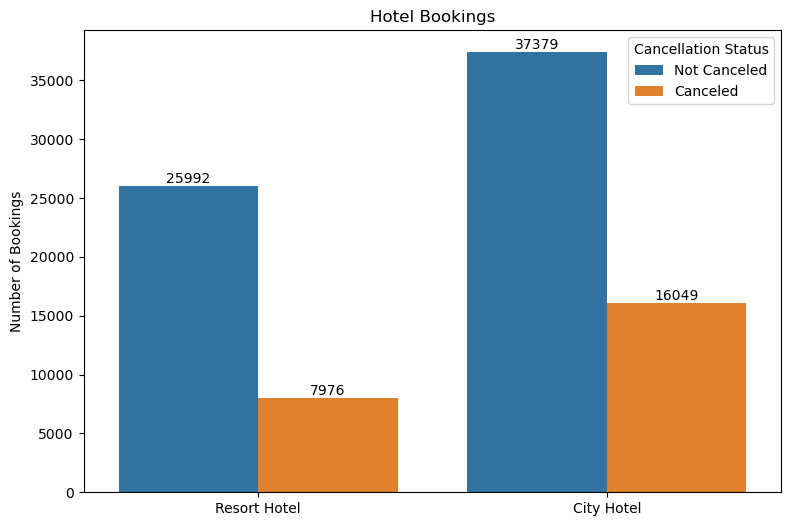

In [12]:
ax = sns.countplot(data=hotels, x='hotel', hue='is_canceled')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.title('Hotel Bookings')
plt.xlabel('')
plt.ylabel('Number of Bookings')
plt.legend(title='Cancellation Status', labels=['Not Canceled', 'Canceled'])
plt.show()



The city hotel has more absolute bookings, both canceled and not canceled, than the resort hotel. A significant porportion of bookings at both hotels are canceled, but the city hotel (30%) has a greater share of bookings canceled than the resort hotel (24%). 

## Bookings by Month

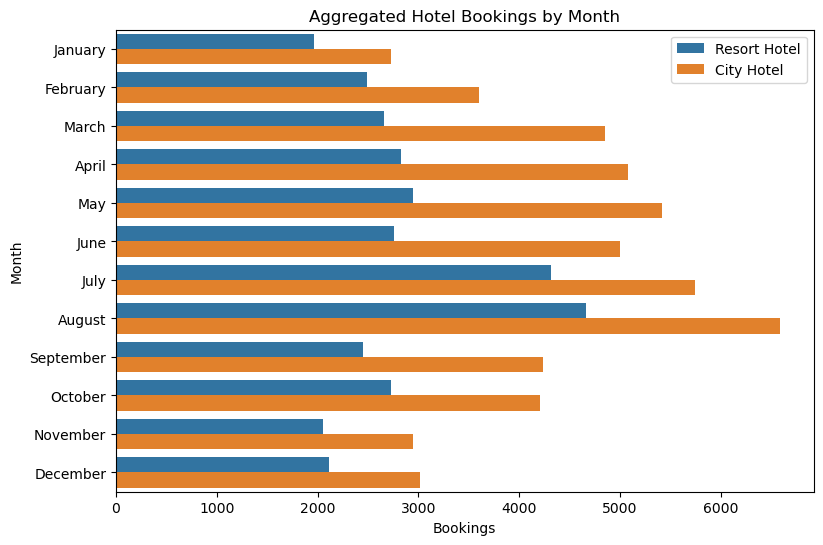

In [13]:
months_ordered = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
sns.countplot(data=hotels, y='arrival_date_month', 
              order=months_ordered, 
              hue='hotel')
plt.xlabel('Bookings')
plt.ylabel('Month')
plt.title('Aggregated Hotel Bookings by Month')
plt.legend()
plt.show()

Both city and resort hotels show similar seasonal variation in bookings, with the most bookings in July and August and the least bookings in the winter months from November to January. Furthermore, although not easily seen in this graph, the city hotel has slightly less variation throughout the year, whereas the resort hotel shows more seasonal variation likely due to its reliance on vacationers.

## Market Segments

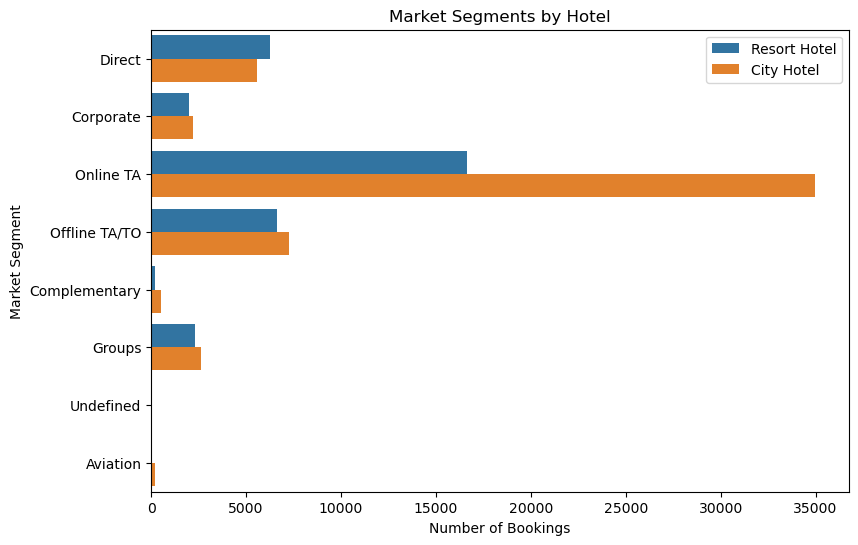

In [15]:
sns.countplot(data=hotels, y='market_segment', hue='hotel')
plt.title('Market Segments by Hotel')
plt.ylabel('Market Segment')
plt.xlabel('Number of Bookings')
plt.legend()
plt.show()

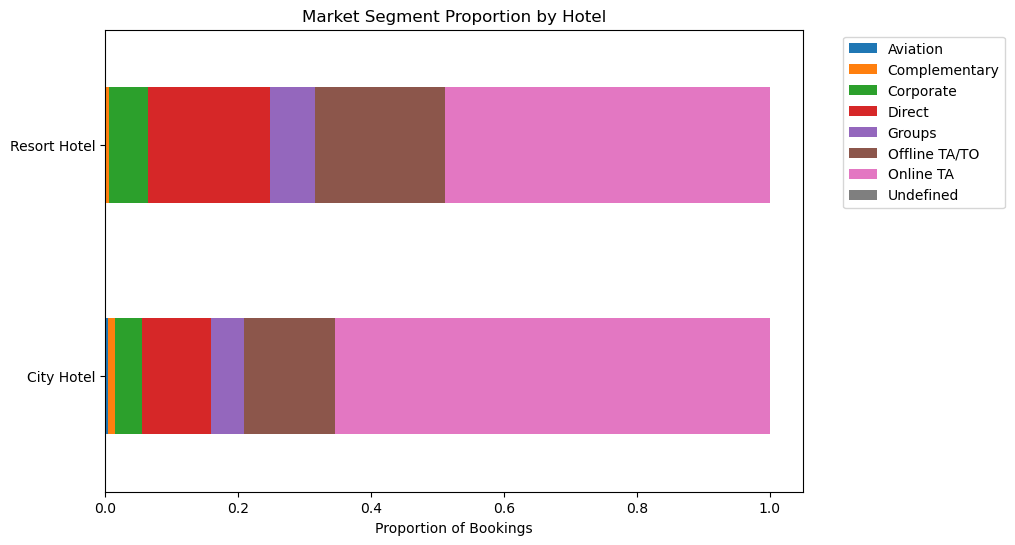

In [16]:
market_segment_counts = hotels.groupby(['hotel', 'market_segment']).size().unstack()
market_segment_proportions = market_segment_counts.divide(hotels.groupby(['hotel']).size(), axis=0)
market_segment_proportions.plot(kind='barh', stacked=True)
plt.title('Market Segment Proportion by Hotel')
plt.ylabel('')
plt.xlabel('Proportion of Bookings')
plt.legend(loc='upper right', bbox_to_anchor=(1.3,1))
plt.show()


Both hotels have a similar pattern of market segments: online travel agents dominate, followed by offline travel agents and direct bookings which have similar proportions. Groups and corporate bookings, again with similar proportions, make up most of the remaining share. Among these top 5 market segments, the resort hotel has a more balanced distribution, whereas the city hotel has over half of all its bookings coming from online travel agents alone.

## Customer Types

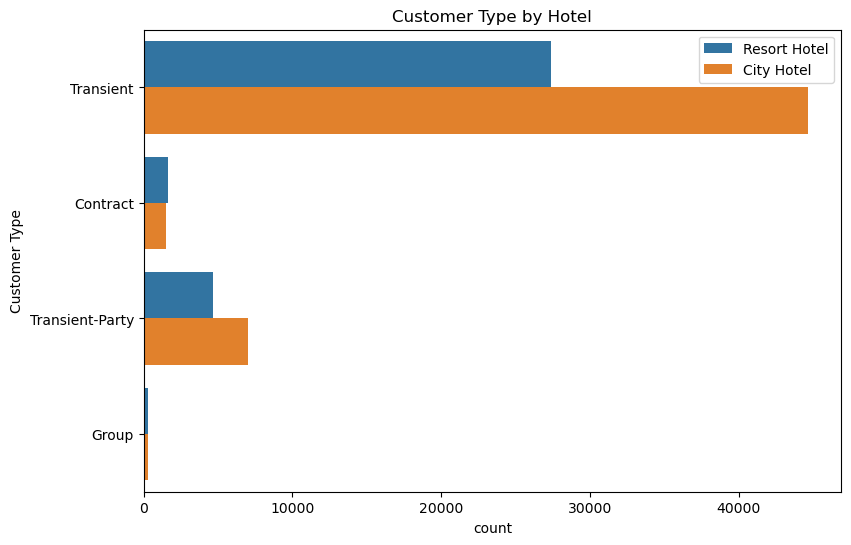

In [106]:
sns.countplot(data=hotels, y='customer_type', hue='hotel')
plt.title('Customer Type by Hotel')
plt.ylabel('Customer Type')
plt.legend()
plt.show()

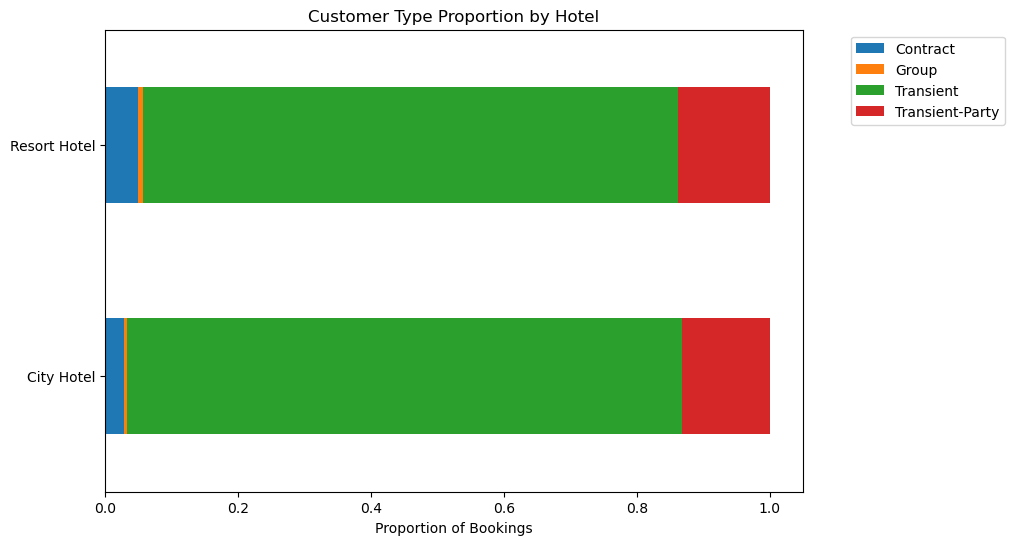

In [18]:
customer_type_counts = hotels.groupby(['hotel', 'customer_type']).size().unstack()
customer_type_proportions = customer_type_counts.divide(hotels.groupby('hotel').size(), axis=0)
customer_type_proportions.plot(kind='barh', stacked=True)
plt.title('Customer Type Proportion by Hotel')
plt.ylabel('')
plt.xticks(rotation=0)
plt.xlabel('Proportion of Bookings')
plt.legend(loc='upper right', bbox_to_anchor=(1.3,1))
plt.show()

The vast majority of bookings at both hotels fall into transient bookings, which are likely individual bookings made without being part of a group or contract. These guests usually book short-term stays and may be traveling for business or leisure purposes. Contract bookings make up a larger portion of total bookings at the resort hotel than at the city hotel, although it still lags heavily behind transient and transient-party bookings.

## Stay Length

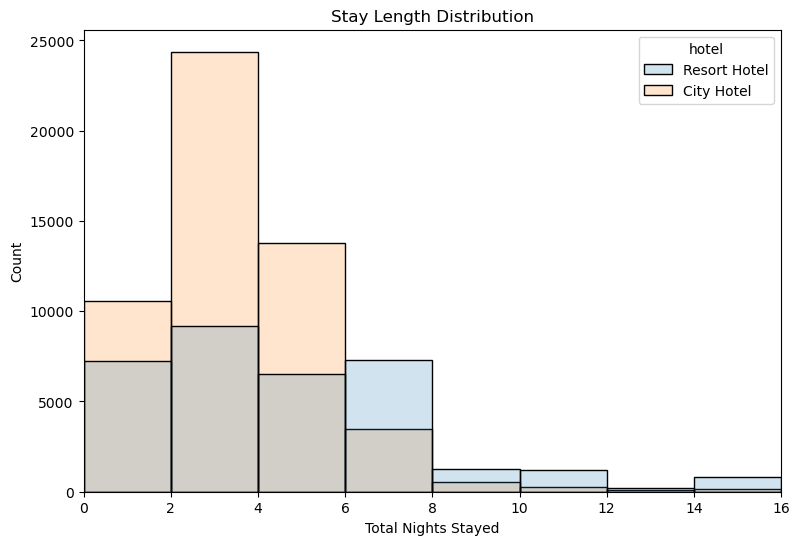

In [14]:
hotels['stays_total_nights'] = hotels.stays_in_weekend_nights + hotels.stays_in_week_nights
sns.histplot(data=hotels, x='stays_total_nights', hue='hotel', binwidth=2, alpha=0.2)
plt.title('Stay Length Distribution')
plt.xlabel('Total Nights Stayed')
plt.xlim(0, 16)
plt.show()

Most guests tend to stay between 1 to 4 nights for both hotels. Resort hotels see slightly more bookings for longer durations (6 or more nights), which could be due to vacationers taking a longer break. City hotels have a more pronounced peak between 2 - 3 nights, suggesting they have a higher proportion of short-term visitors.

## Guests per Booking

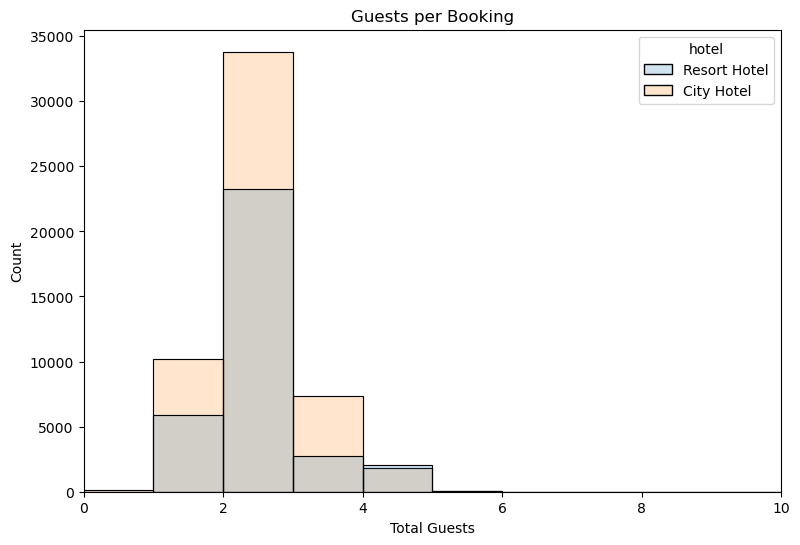

In [19]:
hotels['total_guests'] = hotels.adults + hotels.children + hotels.babies
sns.histplot(data=hotels, x='total_guests', hue='hotel', binwidth=1, alpha=0.2)
plt.xlim(0, 10)
plt.title('Guests per Booking')
plt.xlabel('Total Guests')
plt.show()

Both city and resort hotels have a similar number of total guests per booking, with the distribution peaking at 2 guests. Interestingly, resort hotels have a higher proportion of bookings with 4 guests, which may represent families who vacation at the resort.

## Booking Lead Time

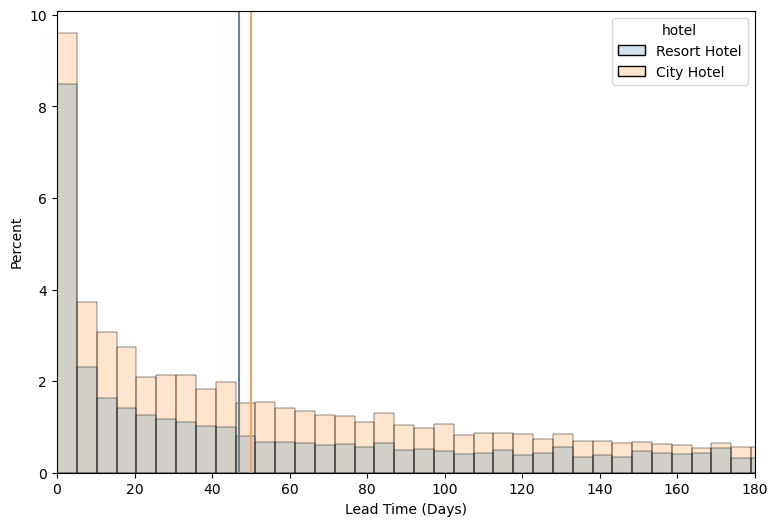

In [20]:
sns.histplot(data=hotels, x='lead_time', hue='hotel', alpha=0.2, stat='percent')
plt.xlim(0, 180)
plt.xlabel('Lead Time (Days)')
plt.axvline(hotels[hotels.hotel == 'City Hotel'].lead_time.quantile(), color='sandybrown')
plt.axvline(hotels[hotels.hotel == 'Resort Hotel'].lead_time.quantile(), color='slategray')
plt.show()

Both the resort hotel and city hotel have a similarly right-skewed distribution of lead time, with the majority of bookings made less than two months out (as shown by the vertical lines denoting the 50th percentile lead time for each hotel).

# Examining cancellations

In order to analyze cancellations, we will divide the data and look at resort and city hotels separately. As noted in our initial review of bookings at each hotel, the city hotel appears to have a higher proportion of cancellations. This may reflect some underlying difference in the nature of bookings or customers at each hotel leading to different cancellation patterns.

In [21]:
resort = hotels[hotels.hotel == 'Resort Hotel']
city = hotels[hotels.hotel == 'City Hotel']

## Bookings and cancellations by month

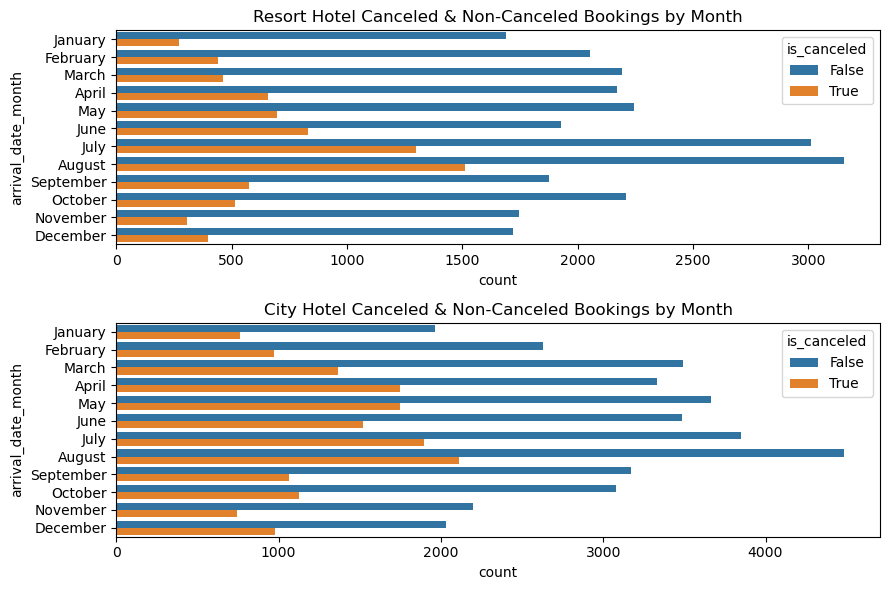

In [22]:
fig, (ax1, ax2) = plt.subplots(2)
sns.countplot(ax=ax1, data=resort, y='arrival_date_month', order=months_ordered, hue='is_canceled')
sns.countplot(ax=ax2, data=city, y='arrival_date_month', order=months_ordered, hue='is_canceled')
ax1.set_title('Resort Hotel Canceled & Non-Canceled Bookings by Month')
ax2.set_title('City Hotel Canceled & Non-Canceled Bookings by Month')
fig.tight_layout()
plt.show()


Both hotels appear to show a similar trend of cancellations, with a peak in the summer months of July and August and a trough in the winter months of November through February. As expected, the city hotel has a higher absolute number of both non-canceled and canceled bookings. Furthermore, the city hotel has slightly less seasonal variation of canceled bookings, whereas the resort hotel shows a more pronounced difference between high cancellation and lwo cancellation periods.

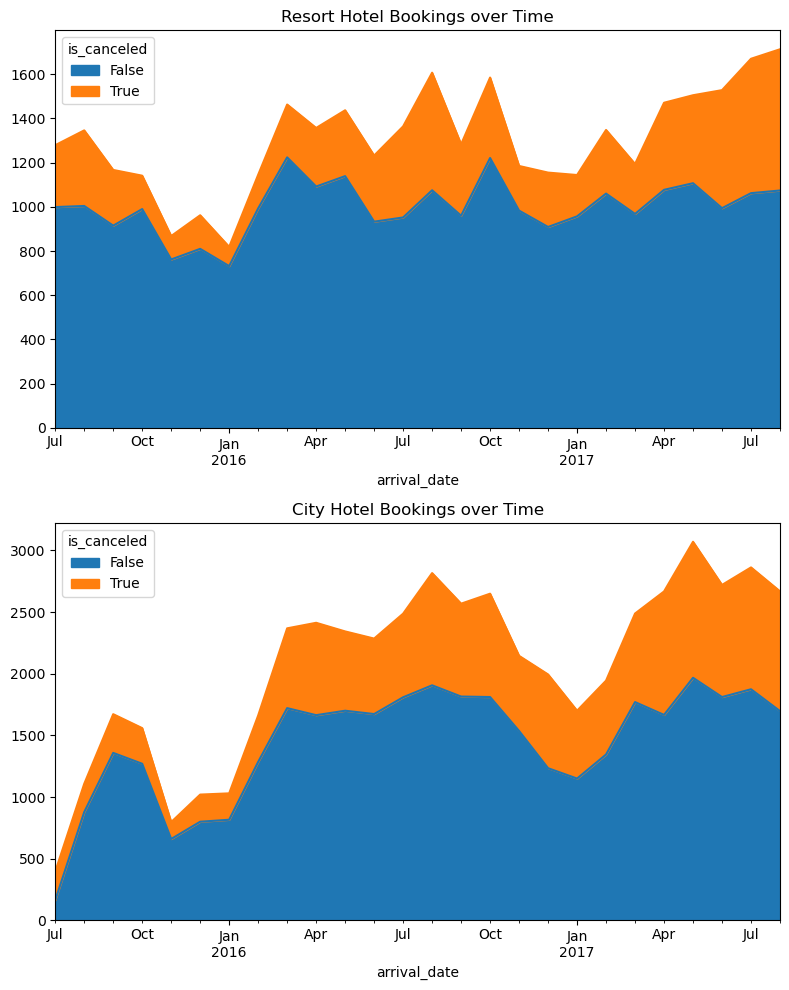

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
resort.groupby([pd.Grouper(key='arrival_date', freq='M'), pd.Grouper(key='is_canceled')]).size().unstack().plot.area(ax=ax1)
city.groupby([pd.Grouper(key='arrival_date', freq='M'), pd.Grouper(key='is_canceled')]).size().unstack().plot.area(ax=ax2)
ax1.set_title('Resort Hotel Bookings over Time')
ax2.set_title('City Hotel Bookings over Time')
fig.tight_layout()
plt.show()


Comparing the area plots for bookings for each hotel more clearly demonstrates that city hotels have a higher proportion of bookings canceled (height of the orange sections). This may reflect differences in clientle for city hotels versus resort hotels. For example, perhaps clients who book at the resort hotel are less likely to cancel because the resort hotel is more out of the way and represents a planned vacation, while the reasons for traveling to the city hotel may be more various and subject to change.

## Cancellation Rate

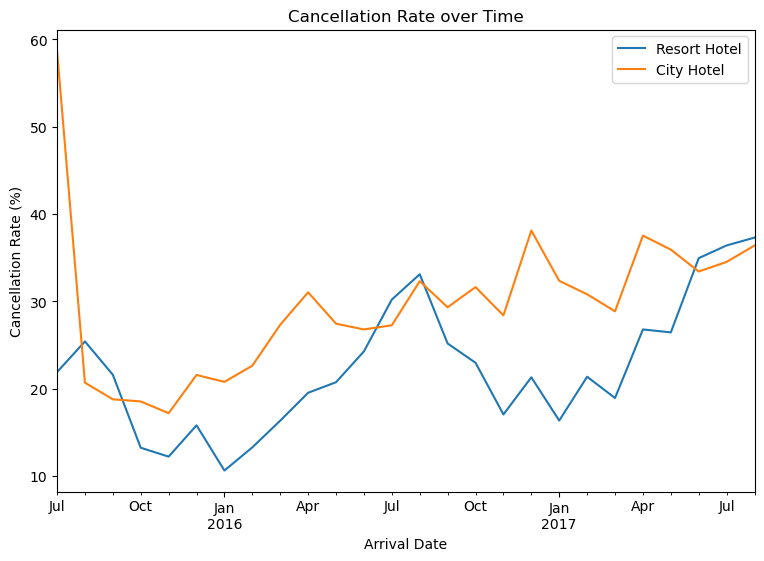

In [24]:
resort_monthly_cancel_count = resort.groupby(pd.Grouper(key='arrival_date', freq='M')).is_canceled.sum()
resort_monthly_total_count = resort.groupby(pd.Grouper(key='arrival_date', freq='M')).size()
resort_monthly_cancel_rate = resort_monthly_cancel_count * 100 / resort_monthly_total_count 
city_monthly_cancel_count = city.groupby(pd.Grouper(key='arrival_date', freq='M')).is_canceled.sum()
city_monthly_total_count = city.groupby(pd.Grouper(key='arrival_date', freq='M')).size()
city_monthly_cancel_rate = city_monthly_cancel_count * 100 / city_monthly_total_count 

resort_monthly_cancel_rate.plot(kind='line', label='Resort Hotel')
city_monthly_cancel_rate.plot(kind='line', label='City Hotel')
plt.legend()
plt.ylabel('Cancellation Rate (%)')
plt.xlabel('Arrival Date')
plt.title('Cancellation Rate over Time')
plt.show()


Cancellation rates for the resort hotel exhibits similar seasonality as seen before: higher proportions of bookings cancelled in the summer months around July and lower cancellation rates in the winter months. While the reasons for this are not obvious, it indicates that people who make bookings for summer months may change their plans more easily than those who make bookings for winter months. This could be because there is a greater variety of alternative choies (either in hotels or destinations) during the summer, luring customers to change their plans.

City hotel cancellation rates are unusually high in the beginning of our dataset's time period, with nearly 60% in July 2015. Interestingly, there doesn't appear to be the same drastic peaks in cancellation rate during summer months when compared with the resort hotel. Overall, except for the very beginning of the time period, cancellation rates for the city hotel are more stable and show less seasonal fluctuation. 



## Effect of booking rates on cancellations

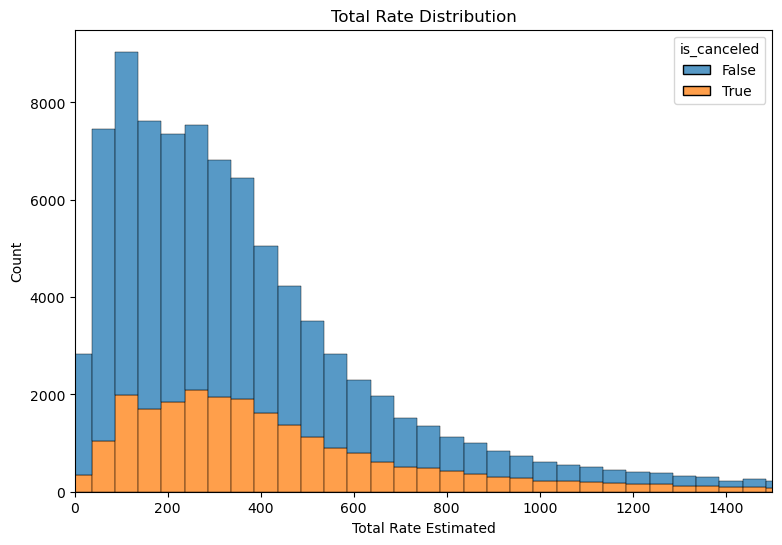

In [25]:
sns.histplot(data=hotels, x='total_rate_estimated', hue='is_canceled', binwidth=50, multiple='stack')
plt.title('Total Rate Distribution')
plt.xlim(0,1500)
plt.xlabel('Total Rate Estimated')
plt.show()

The estimated total rate distribution for the entire dataset shows a heavy right skew, for both canceled and non-canceled booking. Canceled bookings appears to have a peak slightly to the right of that of non-canceled bookings, suggesting there might be a band of pricing where customers are more likely to keep their bookings. As the total rate increases, we see that the count of canceled and non-canceled bookings become more similar, indicating that customers are more likely to cancel their bookings with increasing total rate.

The same pattern can be seen in the following two graphs, which filters for the resort and city hotels respectively.

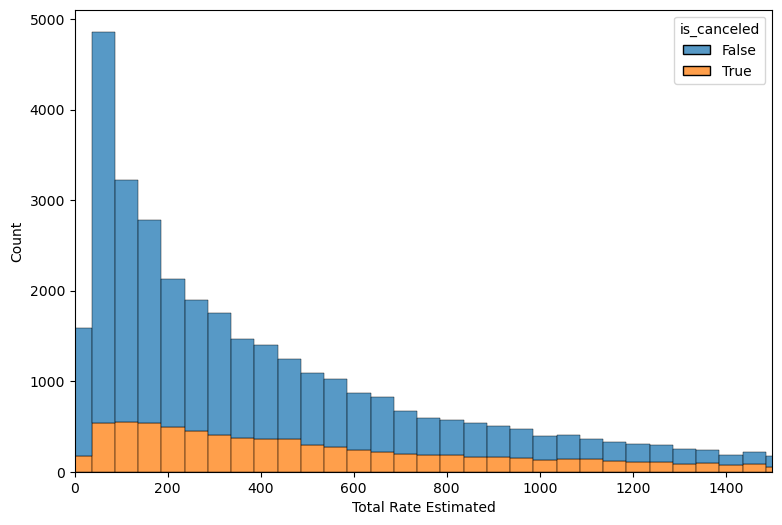

In [26]:
sns.histplot(data=resort, x='total_rate_estimated', hue='is_canceled', binwidth=50, multiple='stack')
plt.xlim(0,1500)
plt.xlabel('Total Rate Estimated')
plt.show()

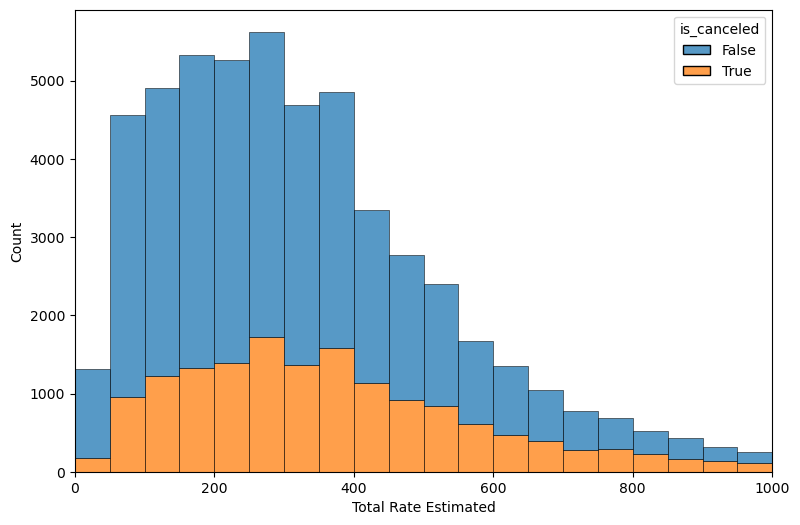

In [27]:
sns.histplot(data=city, x='total_rate_estimated', hue='is_canceled', binwidth=50, multiple='stack')
plt.xlim(0,1000)
plt.xlabel('Total Rate Estimated')
plt.show()

## Number of guests and cancellation status

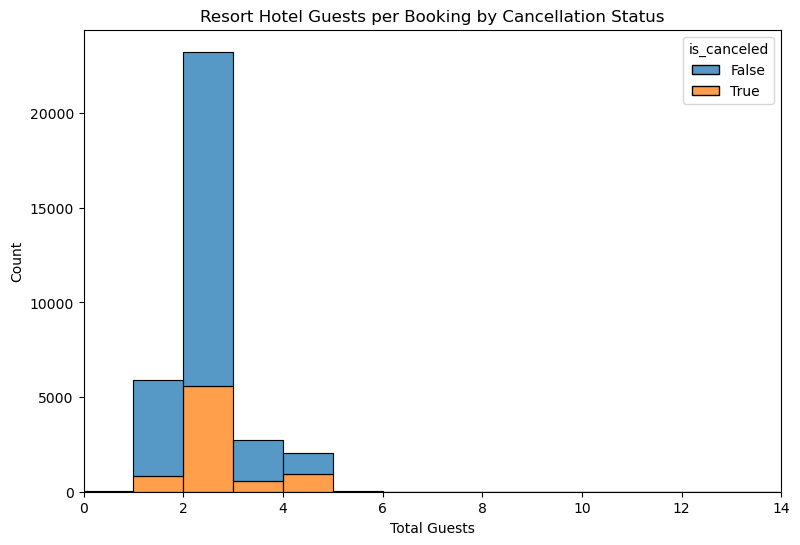

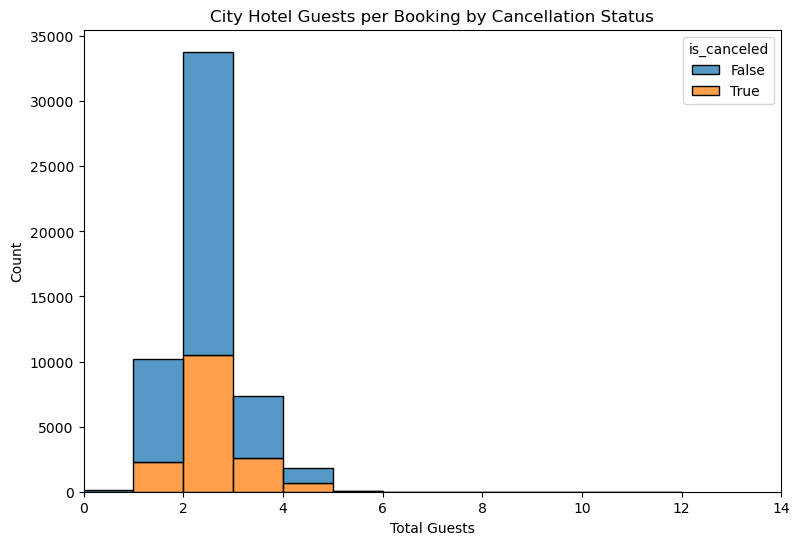

In [29]:
sns.histplot(data=resort, hue='is_canceled', x='total_guests', binwidth=1, multiple='stack')
plt.title('Resort Hotel Guests per Booking by Cancellation Status')
plt.xlabel('Total Guests')
plt.xlim(0,14)
plt.show()

sns.histplot(data=city, hue='is_canceled', x='total_guests', binwidth=1, multiple='stack')
plt.title('City Hotel Guests per Booking by Cancellation Status')
plt.xlabel('Total Guests')
plt.xlim(0,14)
plt.show()

Both canceled and non-canceled bookings peak at 2 guests and have a right-skewed distribution at both hotels, indicating there are a small amount of bookings for a large number of guests. The vast majority of bookings at both htoels are for between 1 to 4 guests. 

The proportion of bookings canceled increases with increasing guest count on a reservation, as seen by the relative portion of each bin that is orange. Increasing guest count, therefore, appears to be associated with cancellations.

## Total Nights Stayed and Cancellation Status

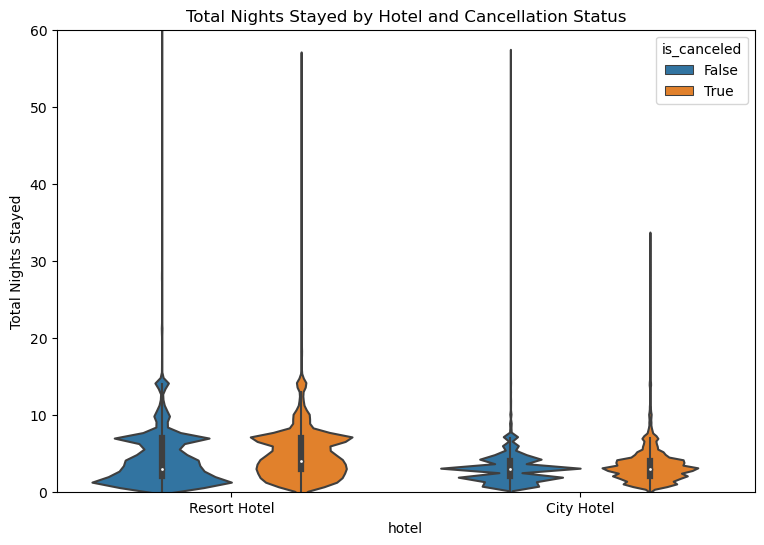

<Figure size 900x600 with 0 Axes>

In [107]:
sns.violinplot(data=hotels, x='hotel', y='stays_total_nights', hue='is_canceled')
plt.title('Total Nights Stayed by Hotel and Cancellation Status')
plt.ylim(0, 60)
plt.ylabel('Total Nights Stayed')
plt.show()
plt.clf()



There doesn't appear to be a significant difference in the distribution of total nights stayed between canceled and non-canceled bookings at each hotel. The median and IQR for total nights stayed is extremely similar at each hotel when comparing canceled and non-canceled bookings.

## Previous uncanceled bookings vs cancellation status

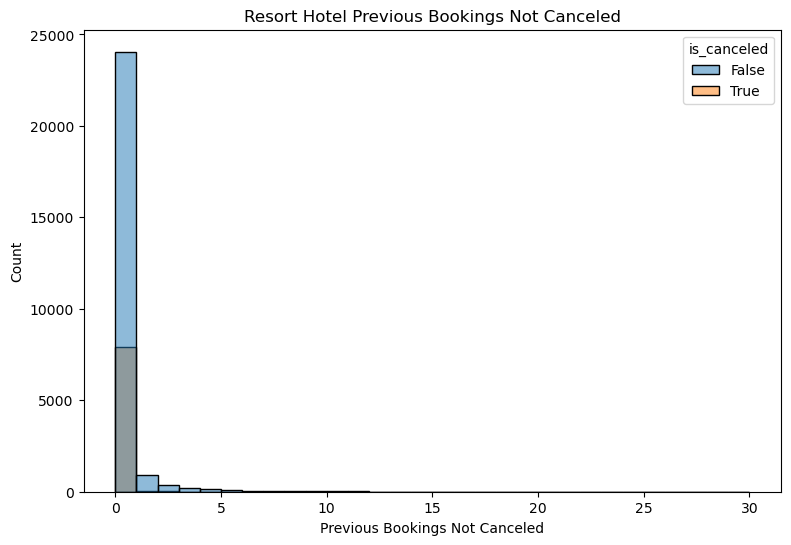

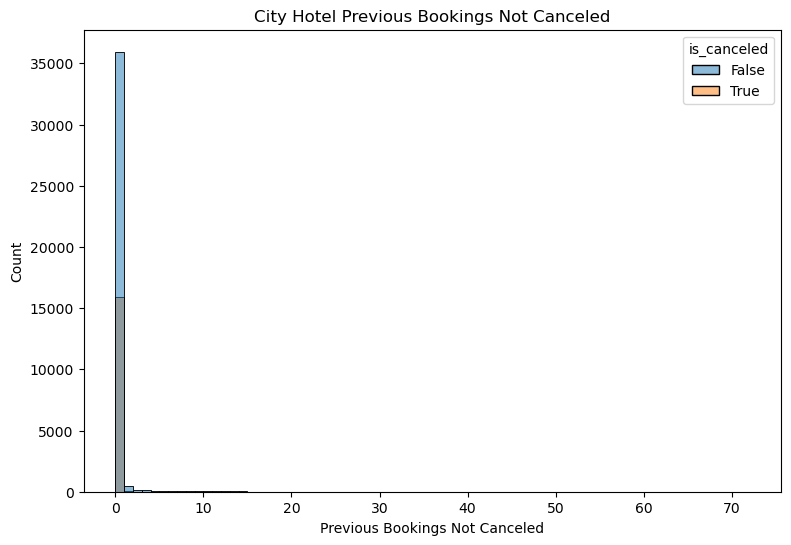

In [31]:
sns.histplot(data=resort, x='previous_bookings_not_canceled', hue='is_canceled', binwidth=1)
plt.title('Resort Hotel Previous Bookings Not Canceled')
plt.xlabel('Previous Bookings Not Canceled')
plt.show()
plt.clf()

sns.histplot(data=city, x='previous_bookings_not_canceled', hue='is_canceled', binwidth=1)
plt.title('City Hotel Previous Bookings Not Canceled')
plt.xlabel('Previous Bookings Not Canceled')
plt.show()


It's hard to see any clear trend here besides the fact that an overwhelming majority of bookings at both hotels were associated with customers without uncanceled previous bookings. This likely means that most customers are booking for the first time with this hotel. For both hotels, a significant of these customers with 0 uncanceled bookings end up canceling their booking.

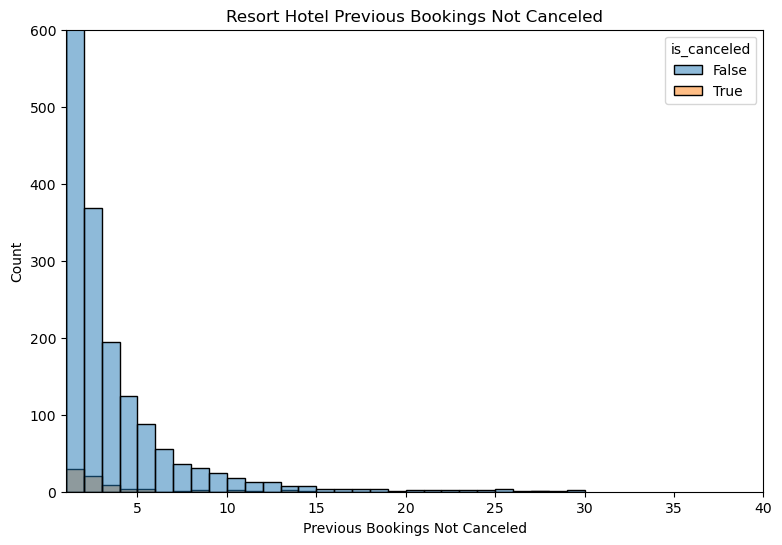

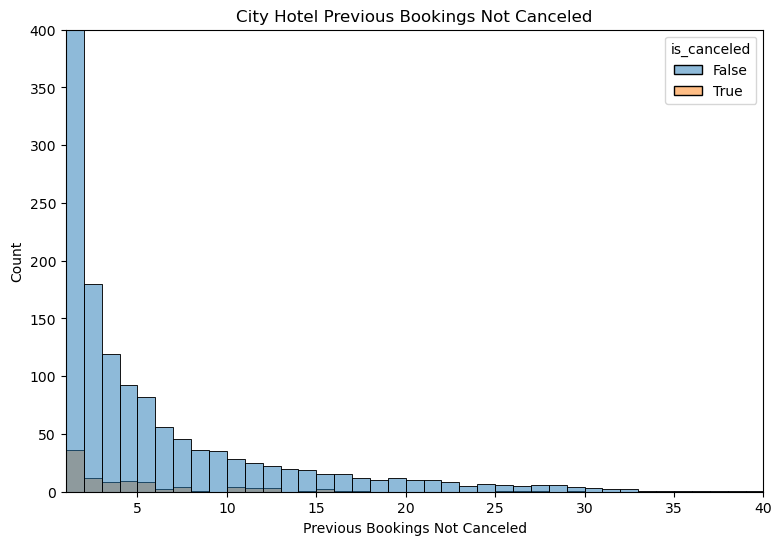

In [32]:
sns.histplot(data=resort, x='previous_bookings_not_canceled', hue='is_canceled', binwidth=1)
plt.title('Resort Hotel Previous Bookings Not Canceled')
plt.xlabel('Previous Bookings Not Canceled')
plt.xlim(1, 40)
plt.ylim(0, 600)
plt.show()
plt.clf()

sns.histplot(data=city, x='previous_bookings_not_canceled', hue='is_canceled', binwidth=1)
plt.title('City Hotel Previous Bookings Not Canceled')
plt.xlabel('Previous Bookings Not Canceled')
plt.xlim(1, 40)
plt.ylim(0, 400)
plt.show()


To more clearly visualize what happens with increasing number of previous uncanceled bookings, we restrict the x-axis to start at 1, thus focusing on all customers with at least 1 previous uncanceled booking. This confirms our hypothesis that, with increasing number of previous uncanceled bookings, a customer is less likely to cancel his/her current booking.



## Previous cancellations and cancellation status

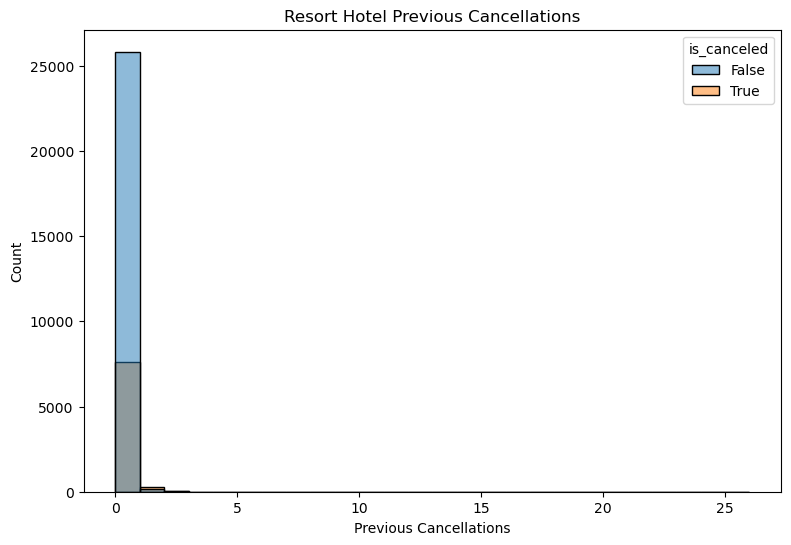

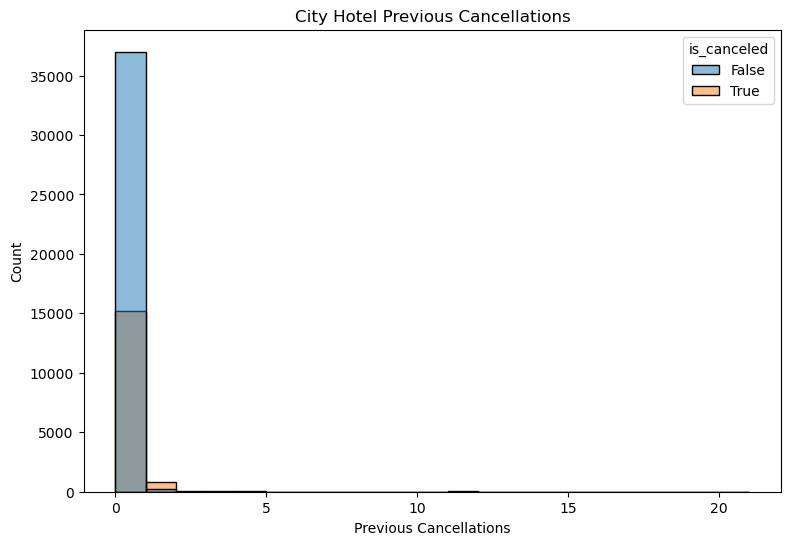

In [33]:
sns.histplot(data=resort, x='previous_cancellations', hue='is_canceled', binwidth=1)
plt.title('Resort Hotel Previous Cancellations')
plt.xlabel('Previous Cancellations')
plt.show()

sns.histplot(data=city, x='previous_cancellations', hue='is_canceled', binwidth=1)
plt.title('City Hotel Previous Cancellations')
plt.xlabel('Previous Cancellations')
plt.show()


Similar to previous uncanceled bookings, most guests did not have any previous cancellations with either hotel, likely because they were new guests. At both hotels, a significant proportion of guests with no previous cancellations ended up canceling their booking, which suggests that a history of no previous cancellations is not necessarily a good indicator that the guest will keep his/her booking.

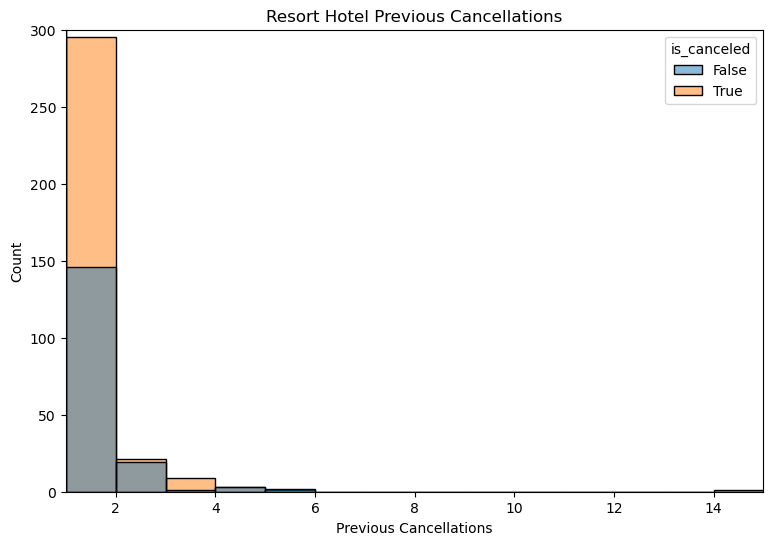

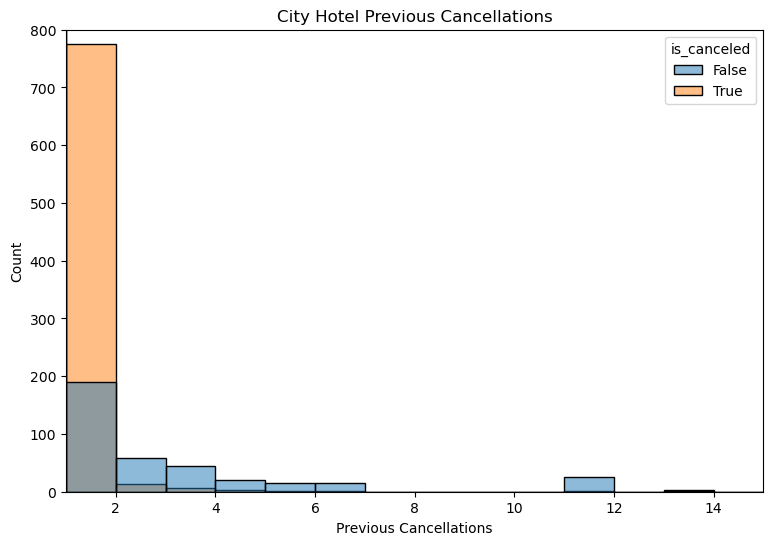

In [34]:
sns.histplot(data=resort, x='previous_cancellations', hue='is_canceled', binwidth=1)
plt.title('Resort Hotel Previous Cancellations')
plt.xlabel('Previous Cancellations')
plt.xlim(1, 15)
plt.ylim(0,300)
plt.show()

sns.histplot(data=city, x='previous_cancellations', hue='is_canceled', binwidth=1)
plt.title('City Hotel Previous Cancellations')
plt.xlabel('Previous Cancellations')
plt.xlim(1, 15)
plt.ylim(0,800)
plt.show()


Again, we limit our x axis to only show customers with 1 or more previous cancellations. Although we expected to see customers with more previous cancellations canceling at higher rates, this was not the case. In fact, customers with 1 previous cancellation canceled at the disproportionately higher rates, but increasing number of previous cancellations beyond 1 was not necessarily associated with greater likelihood of cancellation.

## Percent of previous bookings canceled and cancellation rate

A new column (pct_previous_bookings_canceled) was created using the existing previous cancellations and previous bookings not canceled columns. We hypothesize that customers who canceled a high percentage of their previous bookings were more likely to cancel. 

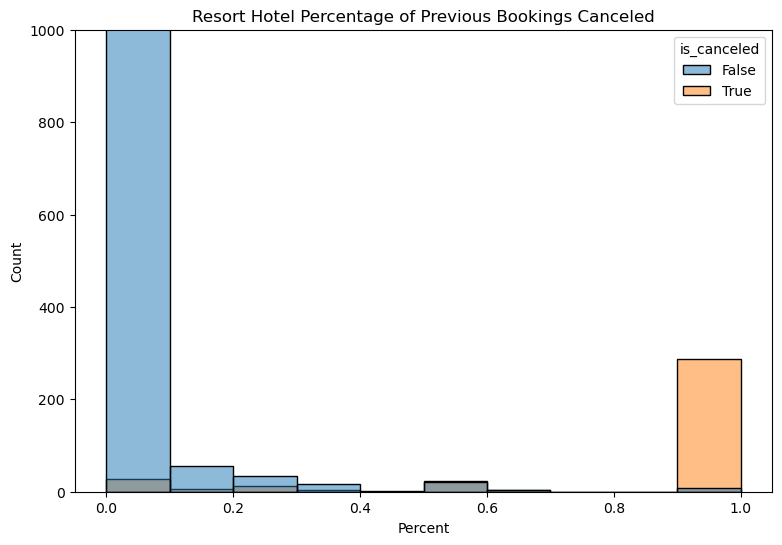

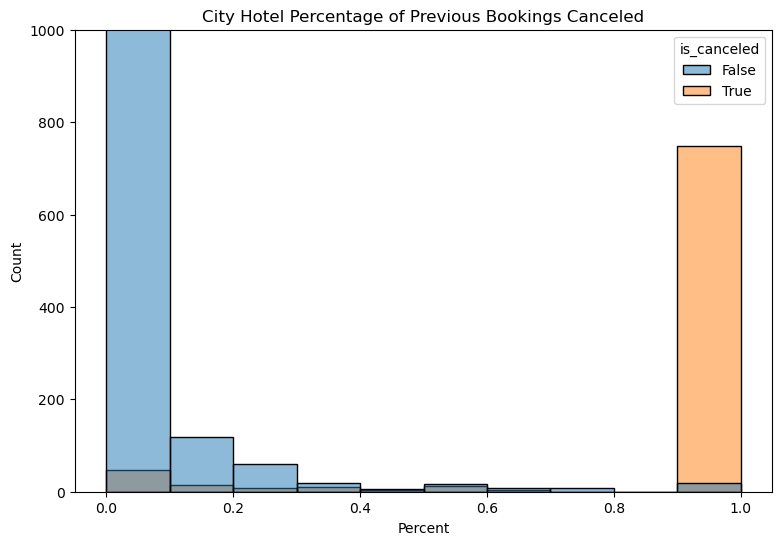

In [35]:
sns.histplot(data=resort, x='pct_previous_bookings_canceled', hue='is_canceled', binwidth=0.1)
plt.title('Resort Hotel Percentage of Previous Bookings Canceled')
plt.xlabel('Percent')
plt.ylim(0,1000)
plt.show()

sns.histplot(data=city, x='pct_previous_bookings_canceled', hue='is_canceled', binwidth=0.1)
plt.title('City Hotel Percentage of Previous Bookings Canceled')
plt.xlabel('Percent')
plt.ylim(0,1000)
plt.show()


The two hotels show a similar trend: customers with a higher percentage of previous bookings canceled are more likely to cancel. This trend can be seen more clearly by zooming into the regions between 0.2 and 0.8 on the histograms. Furthermore, customers who had over 90% cancellation rate of previous bookings were overwhelmingly more likely to cancel than keep their reservations.

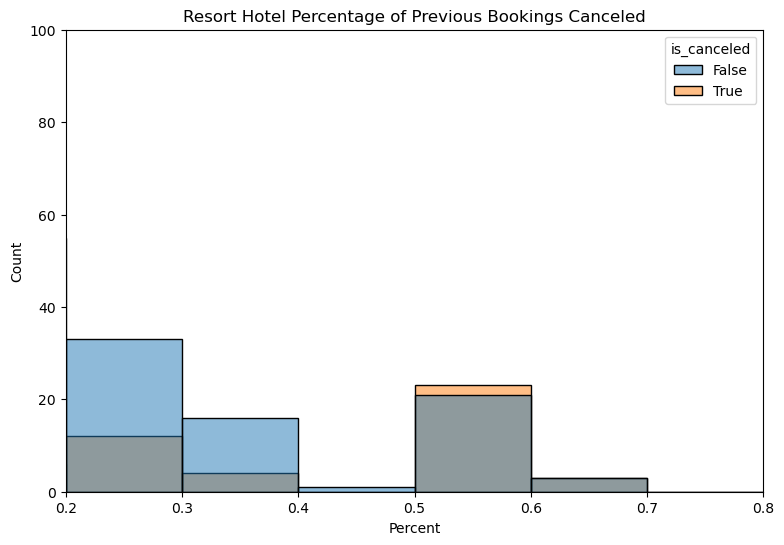

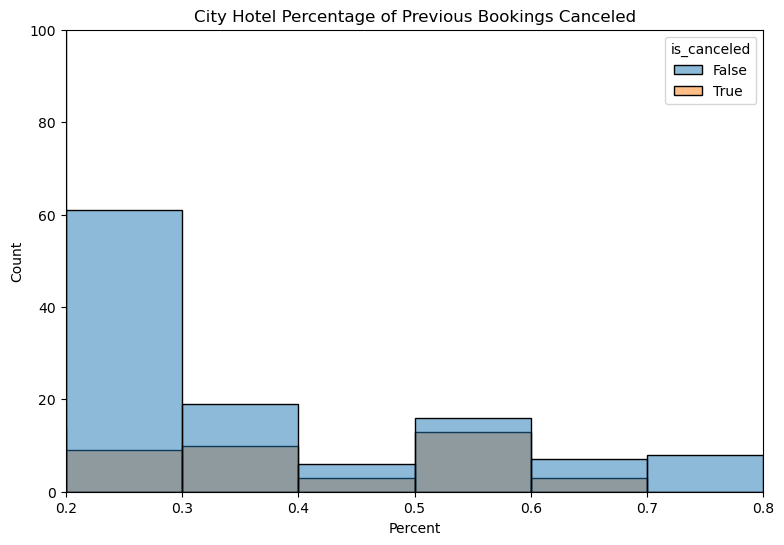

In [36]:
sns.histplot(data=resort, x='pct_previous_bookings_canceled', hue='is_canceled', binwidth=0.1)
plt.title('Resort Hotel Percentage of Previous Bookings Canceled')
plt.xlabel('Percent')
plt.xlim(0.2, 0.8)
plt.ylim(0,100)
plt.show()

sns.histplot(data=city, x='pct_previous_bookings_canceled', hue='is_canceled', binwidth=0.1)
plt.title('City Hotel Percentage of Previous Bookings Canceled')
plt.xlabel('Percent')
plt.xlim(0.2,0.8)
plt.ylim(0,100)
plt.show()


## Lead time and cancellations

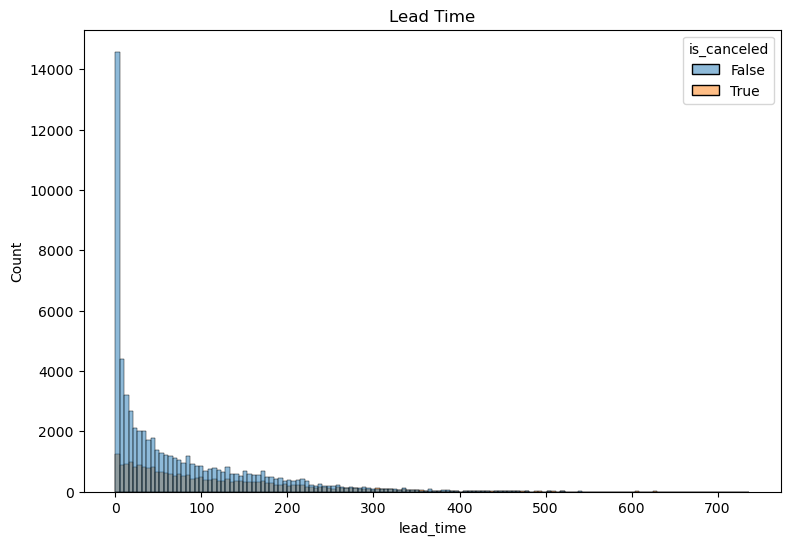

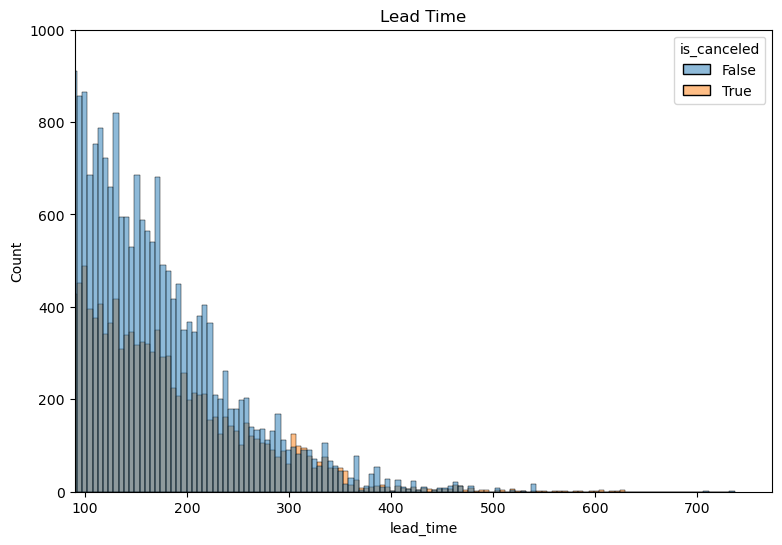

In [108]:
sns.histplot(data=hotels, x='lead_time', hue='is_canceled')
plt.title('Lead Time')
plt.show()


sns.histplot(data=hotels, x='lead_time', hue='is_canceled')
plt.title('Lead Time')
plt.xlim(90, )
plt.ylim(0, 1000)
plt.show()

As lead time increases, the proportion of bookings canceled also reliably increases. This can be seen more easily by restricting the x-axis to lead times greater than 90 days, or about 3 months. We can see that, although both canceled and non-canceled bookings decrease in number with increasing lead time, the non-canceled bookings (blue) decrease at a much faster rate. By around lead_time = 300 days, the number of canceled and non-canceled bookings are roughly equal.

## Parking spaces and cancellations

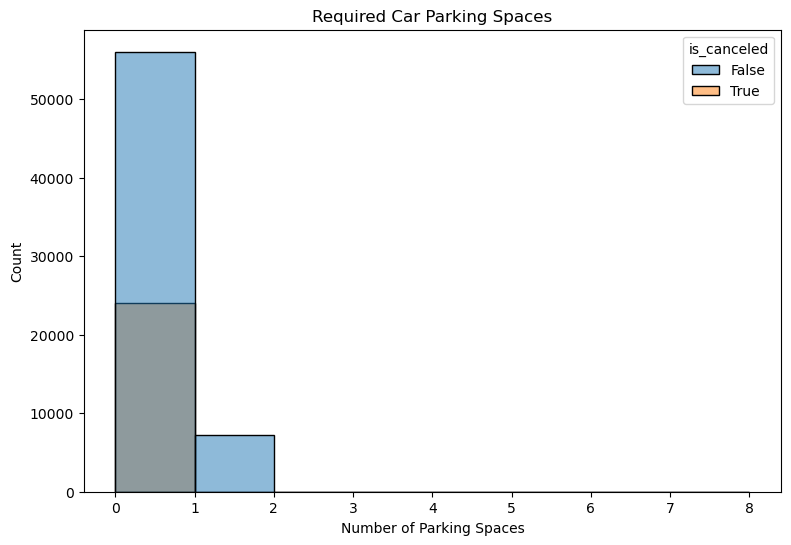

In [133]:
sns.histplot(data=hotels, x='required_car_parking_spaces', binwidth=1, hue='is_canceled')
plt.title('Required Car Parking Spaces')
plt.xlabel('Number of Parking Spaces')
plt.show()

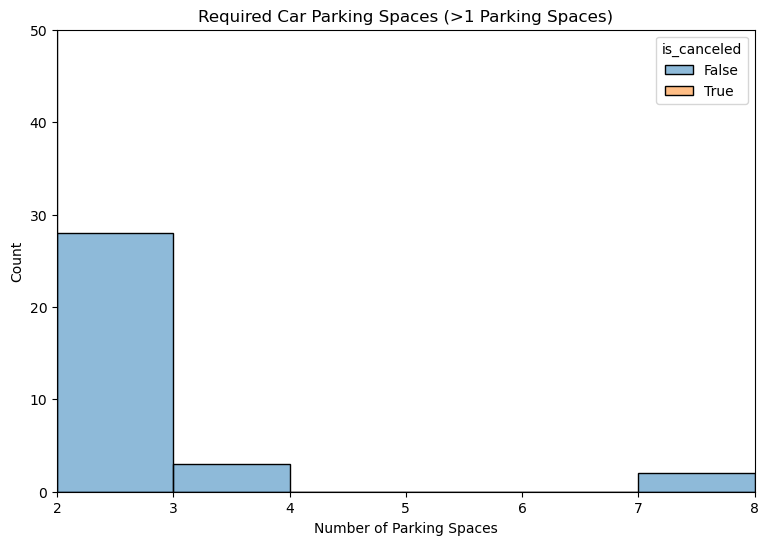

In [135]:
sns.histplot(data=hotels, x='required_car_parking_spaces', binwidth=1, hue='is_canceled')
plt.xlim(2, 8)
plt.ylim(0, 50)
plt.title('Required Car Parking Spaces (>1 Parking Spaces)')
plt.xlabel('Number of Parking Spaces')
plt.show()

In [144]:
hotels[['required_car_parking_spaces', 'is_canceled']].value_counts()

required_car_parking_spaces  is_canceled
0                            False          56058
                             True           24025
1                            False           7280
2                            False             28
3                            False              3
8                            False              2
dtype: int64

Of reservations with 0 required car parking spaces, nearly half were canceled. However, all bookings with any number of parking spaces greater than 0 were kept. This includes 7280 reservations with 1 parking space, 28 reservations with 2 parking spaces, 3 reservations with 3 parking spaces, and 2 reservations with 8 parking spaces. For some reason or another, customers who reserve a parking space seem exceedingly unlikely to cancel their bookings.

## Country of origin vs cancellations

Let's take a look at different countries of origin and their cancellation rates. To focus our efforts, we will look at countries with more than 200 bookings.

In [166]:
cancel_by_country = resort.groupby('country').is_canceled.sum().reset_index(name='cancellations')
bookings_by_country = resort.groupby('country').size().reset_index(name='bookings')

countries = cancel_by_country.merge(bookings_by_country, on='country')
countries['cancel_rate'] = countries.cancellations / countries.bookings
countries_sorted = countries.sort_values(by='bookings', ascending=False)


In [181]:
data = countries_sorted[countries_sorted.bookings > 200].set_index('country')
data

,cancellations,bookings,cancel_rate
country,,,
PRT,4906,14238,0.344571
GBR,686,5905,0.116173
ESP,744,3468,0.214533
IRL,339,1948,0.174025
FRA,187,1425,0.131228
DEU,122,920,0.132609
CN,77,602,0.127907
NLD,51,480,0.106250
USA,65,458,0.141921


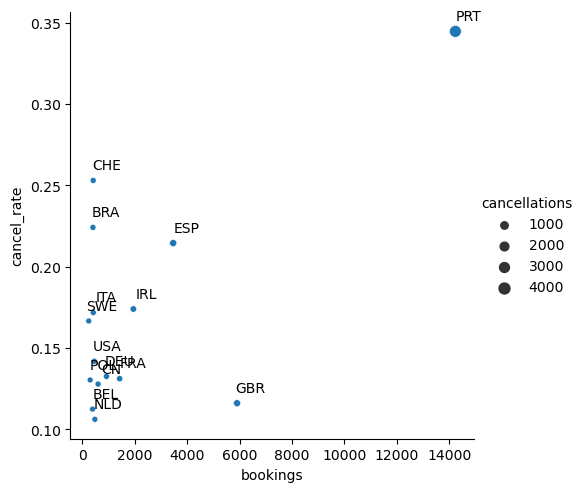

In [184]:
sns.relplot(data=data, x='bookings', y='cancel_rate', size='cancellations')
ax = plt.gca()
for index, row in data.iterrows():
    ax.text(row['bookings'] + 500, row['cancel_rate'] + 0.005, index, fontsize=10, ha='center', va='bottom')
plt.show()

Portugal has the highest number of raw cancellations (4906) as well as highest cancellation rate (35%). This is likely due to the fact that the hotel is located in Portugal, and domestic travelers are more likely to change their plans as travel is more flexible.

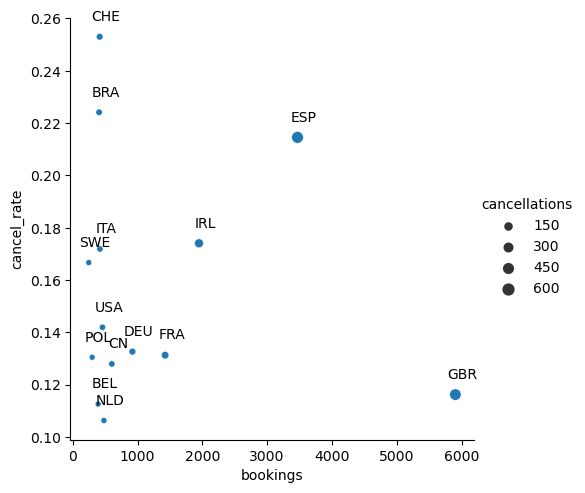

In [186]:
data2 = data.drop('PRT')
data2
sns.relplot(data=data2, x='bookings', y='cancel_rate', size='cancellations')
ax = plt.gca()
for index, row in data2.iterrows():
    ax.text(row['bookings'] + 100, row['cancel_rate'] + 0.005, index, fontsize=10, ha='center', va='bottom')
plt.show()



Dropping Portugal from our dataset allows us to see the other countries better in our scatterplot. Other countries of note are Spain (3rd highest total number of bookings and 4th highest cancellation rate), Switzerland (2nd highest cancellation rate after Portugal), and Brazil (3rd highest cancellation rate). Great Britain, appears to be an outlier in that it has the 2nd highest number of bookings after Portugal but one of the lowest cancellation rates.

## Deposit Type and Cancellation Rate

In [201]:
deposit_cancel = pd.pivot_table(resort, index='deposit_type', values='is_canceled').sort_index()
deposit_cancel

,is_canceled
deposit_type,
No Deposit,0.231511
Non Refund,0.839378
Refundable,0.173913


In [200]:
deposit_counts = resort.groupby('deposit_type')['is_canceled'].value_counts().sort_index(level=['deposit_type', 'is_canceled'])
deposit_counts

deposit_type  is_canceled
No Deposit    False          25885
              True            7798
Non Refund    False             31
              True             162
Refundable    False             76
              True              16
Name: is_canceled, dtype: int64

Contrary to what we expected, non-refundable deposits were cancleed at the highest rate (84%), while no deposit (23%) and refundable (17%) deposit bookings were canceled at much lower rates. It should be noted that both the count of non-refundable and refundable deposits were exceedingly low (193 and 92 respectively), and the vast majority of bookings were made with no deposit. As such, it's hard to draw any conclusions about how deposits and cancellations are associated.

## Developing a regression model to predict cancellation
Having explored the data and gotten a sense of each hotel's overall booking patterns as well as how different variables are related to cancellation, we will develop a regression model to help us potentially predict cancellations.

### Resort Hotel Regression

C:\Users\shawn\AppData\Local\Temp\ipykernel_15592\1586689658.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cancel_corr = resort.corr().is_canceled.sort_values(ascending=False).iloc[2:].round(3)


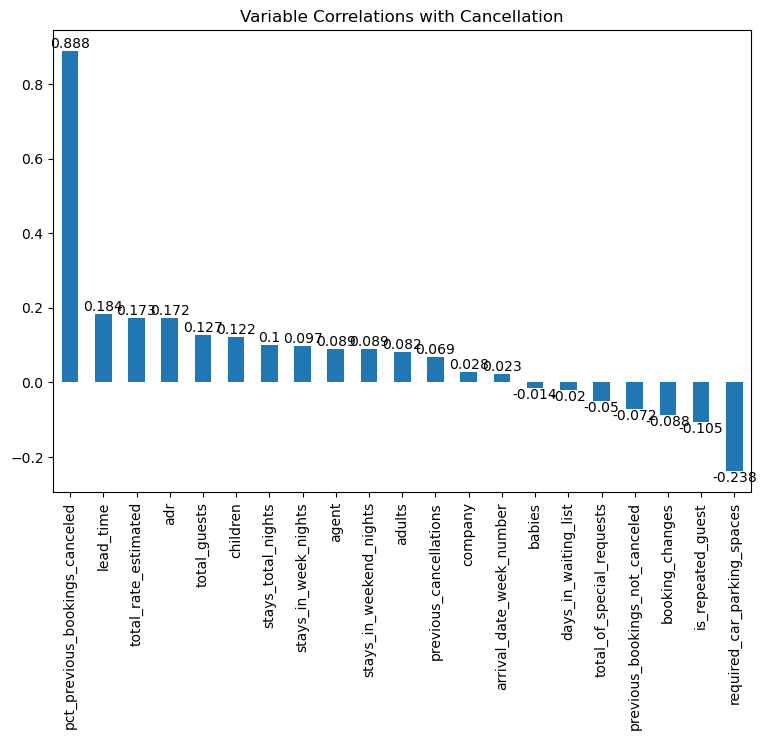

In [70]:
cancel_corr = resort.corr().is_canceled.sort_values(ascending=False).iloc[2:].round(3)
ax = cancel_corr.plot(kind='bar')
ax.bar_label(ax.containers[0])
plt.title('Variable Correlations with Cancellation')
plt.show()

Thee variable most strongly correlated to cancellations is percentage of previous bookings canceled, with a correlation coefficient of 0.888. Other variables with a slight association with cancellations were lead time (r = 0.184), required car parking spaces (r = -0.238), total rate estimated (r = 0.173), and adr (r = 0.172).

In [71]:
resort.dtypes

hotel                                     object
is_canceled                                 bool
lead_time                                  int64
arrival_date_year                         object
arrival_date_month                        object
arrival_date_week_number                   int64
arrival_date_day_of_month                 object
stays_in_weekend_nights                    int64
stays_in_week_nights                       int64
adults                                     int64
children                                 float64
babies                                     int64
meal                                      object
country                                   object
market_segment                            object
distribution_channel                      object
is_repeated_guest                           bool
previous_cancellations                     int64
previous_bookings_not_canceled             int64
reserved_room_type                        object
assigned_room_type  

In [72]:
market_segment = pd.get_dummies(resort['market_segment'])
customer_type = pd.get_dummies(resort['customer_type'])
distribution_channel = pd.get_dummies(resort['distribution_channel'], prefix='dist')
meal = pd.get_dummies(resort['meal'], prefix='meal')
reserved_room_type = pd.get_dummies(resort['reserved_room_type'], prefix='reserved')
assigned_room_type = pd.get_dummies(resort['assigned_room_type'], prefix='assigned')
deposit_type = pd.get_dummies(resort['deposit_type'])
arrival_date_month = pd.get_dummies(resort['arrival_date_month'])
arrival_date_year = pd.get_dummies(resort['arrival_date_year'])
arrival_date_day_of_month = pd.get_dummies(resort['arrival_date_day_of_month'])
df = pd.concat([resort, market_segment, customer_type, distribution_channel,
               meal, reserved_room_type, assigned_room_type, deposit_type,
               arrival_date_month, arrival_date_year, arrival_date_day_of_month], axis=1)

In [73]:
from sklearn.linear_model import LogisticRegression

#When you create a Logistic Regression Model there needs to be a HOLD OUT SET for testing and a TRAINING set

from sklearn.model_selection import train_test_split

#X is independent
#Y is dependent

X = df[['pct_previous_bookings_canceled', 'lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
        'adults', 'children', 'babies',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests', 
        'stays_total_nights', 'total_guests', 'total_rate_estimated',
        'Complementary', 'dist_Corporate', 'Direct', 'Groups',
       'Offline TA/TO', 'Online TA', 'Contract', 'Group', 'Transient',
       'Transient-Party', 'Corporate', 'dist_Direct', 'dist_TA/TO', 'dist_Undefined','meal_BB', 'meal_FB', 'meal_HB', 'meal_SC', 'meal_Undefined', 'reserved_A', 'reserved_B', 'reserved_C', 'reserved_D', 'reserved_E',
       'reserved_F', 'reserved_G', 'reserved_H', 'reserved_L', 'reserved_P', 'assigned_A', 'assigned_B', 'assigned_C', 'assigned_D', 'assigned_E',
       'assigned_F', 'assigned_G', 'assigned_H', 'assigned_I', 'assigned_L',
       'assigned_P',
       'No Deposit', 'Non Refund', 'Refundable', 'April', 'August', 'December',
       'February', 'January', 'July', 'June', 'March', 'May', 'November',
       'October', 'September', '2015',
       '2016', '2017', '1', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28',
       '29', '3', '30', '31', '4', '5', '6', '7', '8', '9']].fillna(0)

y = df['is_canceled_int']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=8)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)





C:\Users\shawn\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [74]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)


Text(0.5, 533.5555555555555, 'Predicted label')

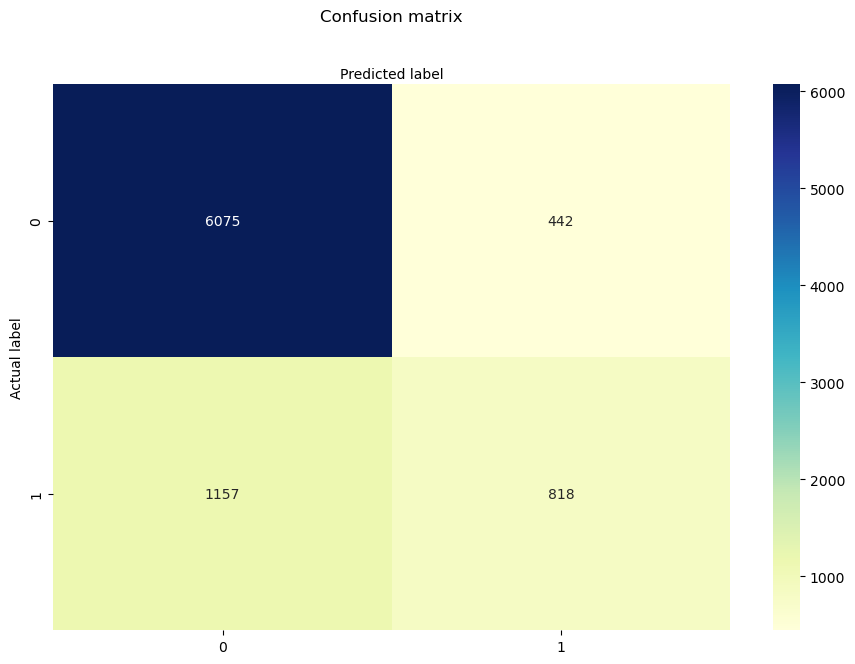

In [75]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


In [76]:
from sklearn.metrics import classification_report
target_names = ['Not Canceled', 'Canceled']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

Not Canceled       0.84      0.93      0.88      6517
    Canceled       0.65      0.41      0.51      1975

    accuracy                           0.81      8492
   macro avg       0.74      0.67      0.69      8492
weighted avg       0.80      0.81      0.80      8492



Our logistic regression model for the resort hotel has good precision (0.84), recall (0.93), and f1-score (0.88) for non-canceled bookings. For canceled bookings, it fares worse, with 0.65 precision, 0.41 recall, and 0.51 f1-score. However, with a 0.65 precision for canceled bookings, it may still be of use to hotels in predicting when a customer might be likely to cancel.

<Axes: ylabel='Feature'>

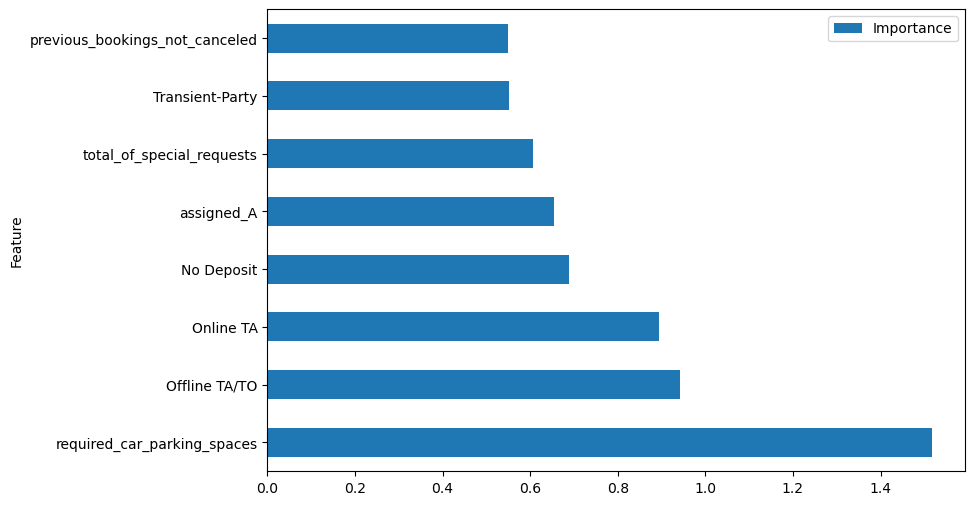

In [81]:
coefficients = logreg.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
feature_importance.iloc[:8].plot(x='Feature', y='Importance', kind='barh')

To best understand which variables are most important in our regression model, we extracted and plotted the absolute values of the 8 most important features. Required car parking spaces had the highest feature importance, followed by offline TA/TO and online TA (both market segment variables). 

### City Hotel Regression

We repeat the above process for our city hotel dataset.

C:\Users\shawn\AppData\Local\Temp\ipykernel_15592\1358409935.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cancel_corr = city.corr().is_canceled.sort_values(ascending=False).iloc[2:].round(3)


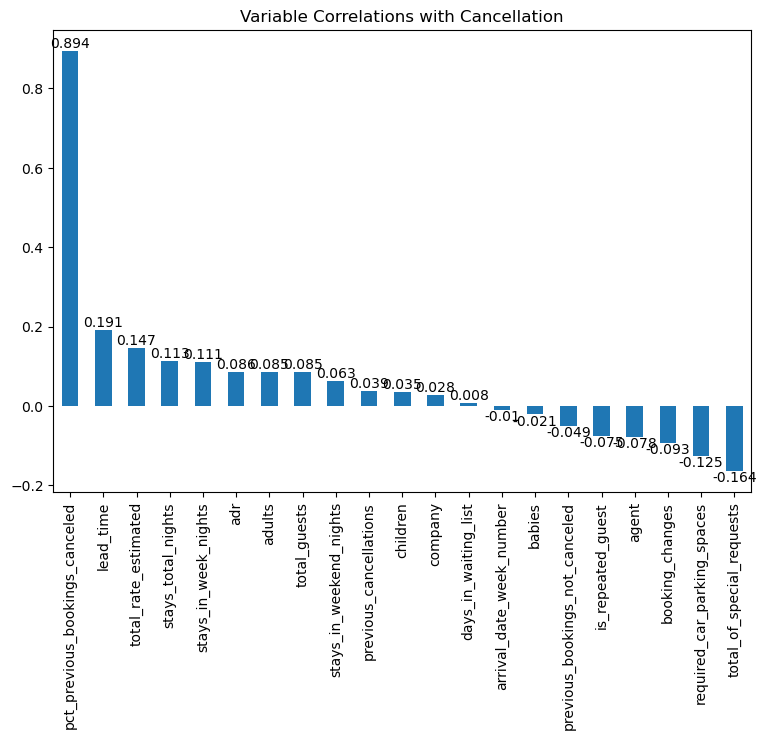

In [51]:
cancel_corr = city.corr().is_canceled.sort_values(ascending=False).iloc[2:].round(3)
ax = cancel_corr.plot(kind='bar')
ax.bar_label(ax.containers[0])
plt.title('Variable Correlations with Cancellation')
plt.show()

Overall, the pattern of which variables are most strongly correlated with cancellations is the same as earlier in our resort hotel analysis.

In [52]:
city.dtypes

hotel                                     object
is_canceled                                 bool
lead_time                                  int64
arrival_date_year                         object
arrival_date_month                        object
arrival_date_week_number                   int64
arrival_date_day_of_month                 object
stays_in_weekend_nights                    int64
stays_in_week_nights                       int64
adults                                     int64
children                                 float64
babies                                     int64
meal                                      object
country                                   object
market_segment                            object
distribution_channel                      object
is_repeated_guest                           bool
previous_cancellations                     int64
previous_bookings_not_canceled             int64
reserved_room_type                        object
assigned_room_type  

In [85]:
market_segment = pd.get_dummies(city['market_segment'])
customer_type = pd.get_dummies(city['customer_type'])
distribution_channel = pd.get_dummies(city['distribution_channel'], prefix='dist')
meal = pd.get_dummies(city['meal'], prefix='meal')
reserved_room_type = pd.get_dummies(city['reserved_room_type'], 'reserved')
assigned_room_type = pd.get_dummies(city['assigned_room_type'], 'assigned')
deposit_type = pd.get_dummies(city['deposit_type'])
arrival_date_month = pd.get_dummies(city['arrival_date_month'])
arrival_date_year = pd.get_dummies(city['arrival_date_year'])
arrival_date_day_of_month = pd.get_dummies(city['arrival_date_day_of_month'])
df = pd.concat([city, market_segment, customer_type, distribution_channel,
               meal, reserved_room_type, assigned_room_type, deposit_type,
               arrival_date_month, arrival_date_year, arrival_date_day_of_month], axis=1)

In [86]:
independent_variables = list(df.columns)
independent_variables

['hotel',
 'is_canceled',
 'lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'assigned_room_type',
 'booking_changes',
 'deposit_type',
 'agent',
 'company',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'reservation_status',
 'reservation_status_date',
 'arrival_date',
 'total_rate_estimated',
 'pct_previous_bookings_canceled',
 'is_canceled_int',
 'stays_total_nights',
 'total_guests',
 'Aviation',
 'Complementary',
 'Corporate',
 'Direct',
 'Groups',
 'Offline TA/TO',
 'Online TA',
 'Undefined',
 'Contract',
 'Group',
 'Transient',
 'Transient-Party',
 'dist_Corporate',
 'dist_Direct',
 'dist_G

In [87]:
X = df[[
 'lead_time',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'total_rate_estimated',
 'pct_previous_bookings_canceled',
 'stays_total_nights',
 'total_guests',
 'Aviation',
 'Complementary',
 'Corporate',
 'Direct',
 'Groups',
 'Offline TA/TO',
 'Online TA',
 'Undefined',
 'Contract',
 'Group',
 'Transient',
 'Transient-Party',
 'dist_Corporate',
 'dist_Direct',
 'dist_GDS',
 'dist_TA/TO',
 'dist_Undefined',
 'meal_BB',
 'meal_FB',
 'meal_HB',
 'meal_SC',
 'reserved_A',
 'reserved_B',
 'reserved_C',
 'reserved_D',
 'reserved_E',
 'reserved_F',
 'reserved_G',
 'reserved_P',
 'assigned_A',
 'assigned_B',
 'assigned_C',
 'assigned_D',
 'assigned_E',
 'assigned_F',
 'assigned_G',
 'assigned_K',
 'assigned_P',
 'No Deposit',
 'Non Refund',
 'Refundable',
 'April',
 'August',
 'December',
 'February',
 'January',
 'July',
 'June',
 'March',
 'May',
 'November',
 'October',
 'September',
 '2015',
 '2016',
 '2017',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']].fillna(0)

y = df['is_canceled_int']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=8)

logreg = LogisticRegression() 

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)


C:\Users\shawn\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [88]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)


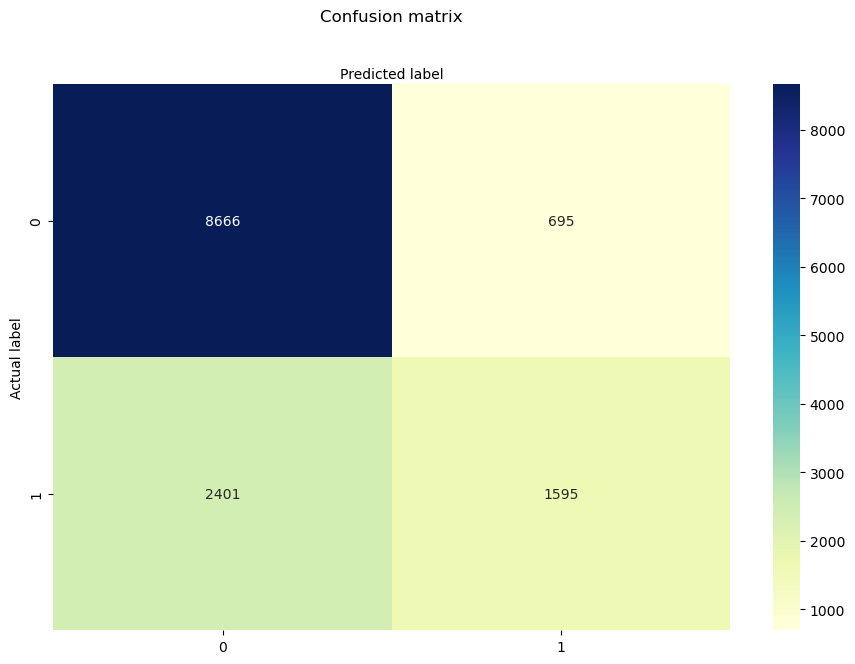

In [202]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


In [90]:
target_names = ['Not Canceled', 'Canceled']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

Not Canceled       0.78      0.93      0.85      9361
    Canceled       0.70      0.40      0.51      3996

    accuracy                           0.77     13357
   macro avg       0.74      0.66      0.68     13357
weighted avg       0.76      0.77      0.75     13357



Our model for the city hotel performs slightly weaker than that for the resort hotel, with an overall f-score of 0.77 compared to 0.81 for the resort hotel. Focusing on canceled bookings, the precision is slightly higher at 0.70, indicating that our model can correctly identify bookings which will be canceled 70% of the time. This model may thus be a useful tool for hotels attempting to better get ahead of potential cancellations.

<Axes: ylabel='Feature'>

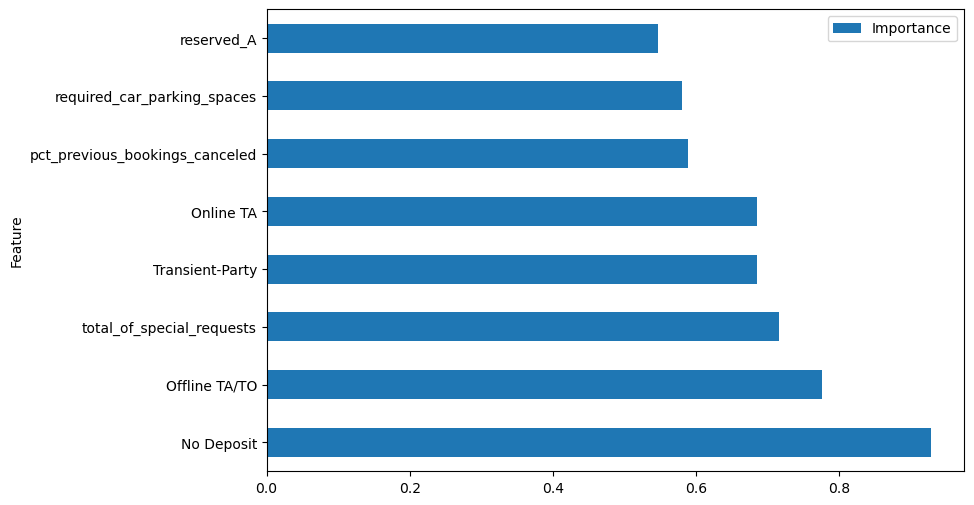

In [91]:
coefficients = logreg.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=False).iloc[:8]
feature_importance.plot(x='Feature', y='Importance', kind='barh')

The most important features in our city hotel model differ from earlier. Here, deposit status (especially no deposit) is the most important feature, followed by offline TA/TO and total number of special requests. 

## Insights

* Both hotels have a significant proportion (about a quarter) of their bookings canceled, although the city hotel has a slightly higher proportion canceled. However, in terms of absolute numbers of bookings, the city hotel has both more bookings and cancellations, which makes sense given its location in a large city (Lisbon). 

* The two hotels also share a similar seasonal variation when it comes to bookings, with the most bookings in summer and the least in winter. 

* Stay length was centered around 1-4 nights for both hotels, although the resort hotel had slightly more longer stays while the city hotel seems to attract more short-term visitors. 

* Average guest number and lead time were also similar, with 2 guests being the most common number of guests per booking. The resort hotel did have more large groups with 4 guests, which may indicate families vacationing at the resort.

* The top 3 countries of origin were Portugal, Great Britain, and Spain. Portugal had the highest booking count and cancellation rates, whereas Great Britain had one of the lowest cancellation rates despite having the second most bookings.

* The variables that were most correlated with cancellations was percent of previous bookings canceled at both hotels (r = 0.89). Other variables that were slightly correlated were lead time, total rate, average daily rate, total car parking spaces, and total special requests.
